In [1]:
# download from https://psi.engr.tamu.edu/l2-arctic-corpus/
import numpy as np

import zipfile
import textgrids
from torch.utils.data import Dataset

from IPython.display import clear_output

In [2]:
with zipfile.ZipFile('../.data/l2arctic_release_v5.0.zip', 'r') as zip_ref:
    print(zip_ref.read('README.md').decode('utf-8'))

clear_output() # comment out if you want to see the README

In [3]:
SPEAKER_INFO = {
    'ABA': {
        'gender': 'M',
        'native-language': 'Arabic',
    },
    'SKA': {
        'gender': 'F',
        'native-language': 'Arabic',
    },
    'YBAA': {
        'gender': 'M',
        'native-language': 'Arabic',
    },
    'ZHAA': {
        'gender': 'F',
        'native-language': 'Arabic',
    },
    'BWC': {
        'gender': 'M',
        'native-language': 'Chinese',
    },
    'LXC': {
        'gender': 'F',
        'native-language': 'Chinese',
    },
    'NCC': {
        'gender': 'F',
        'native-language': 'Chinese',
    },
    'TXHC': {
        'gender': 'M',
        'native-language': 'Chinese',
    },
    'ASI': {
        'gender': 'M',
        'native-language': 'Hindi',
    },
    'RRBI': {
        'gender': 'M',
        'native-language': 'Hindi',
    },
    'SVBI': {
        'gender': 'F',
        'native-language': 'Hindi',
    },
    'TNI': {
        'gender': 'F',
        'native-language': 'Hindi',
    },
    'HJK': {
        'gender': 'F',
        'native-language': 'Korean',
    },
    'HKK': {
        'gender': 'M',
        'native-language': 'Korean',
    },
    'YDCK': {
        'gender': 'F',
        'native-language': 'Korean',
    },
    'YKWK': {
        'gender': 'M',
        'native-language': 'Korean',
    },
    'EBVS': {
        'gender': 'M',
        'native-language': 'Spanish',
    },
    'ERMS': {
        'gender': 'M',
        'native-language': 'Spanish',
    },
    'MBMPS': {
        'gender': 'F',
        'native-language': 'Spanish',
    },
    'NJS': {
        'gender': 'F',
        'native-language': 'Spanish',
    },
    'HQTV': {
        'gender': 'M',
        'native-language': 'Vietnamese',
    },
    'PNV': {
        'gender': 'F',
        'native-language': 'Vietnamese',
    },
    'THV': {
        'gender': 'F',
        'native-language': 'Vietnamese',
    },
    'TLV': {
        'gender': 'M',
        'native-language': 'Vietnamese',
    }
}

In [45]:
ARPABET2IPA = {'AA':'ɑ','AE':'æ','AH':'ʌ','AH0':'ə','AO':'ɔ','AW':'aʊ','AY':'aɪ','EH':'ɛ','ER':'ɝ','ER0':'ɚ','EY':'eɪ','IH':'ɪ','IH0':'ɨ','IY':'i','OW':'oʊ','OY':'ɔɪ','UH':'ʊ','UW':'u','B':'b','CH':'tʃ','D':'d','DH':'ð','EL':'l̩ ','EM':'m̩','EN':'n̩','F':'f','G':'ɡ','HH':'h','JH':'dʒ','K':'k','L':'l','M':'m','N':'n','NG':'ŋ','P':'p','Q':'ʔ','R':'ɹ','S':'s','SH':'ʃ','T':'t','TH':'θ','V':'v','W':'w','WH':'ʍ','Y':'j','Z':'z','ZH':'ʒ'}
IPA_SUBSTITUTIONS = {
    'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
    'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
    'l̩': 'l',   # Remove syllabic marker from 'l̩'
    'm̩': 'm',   # Remove syllabic marker from 'm̩'
    'n̩': 'n',   # Remove syllabic marker from 'n̩'
    '̩': '',     # Remove syllabic marker
    'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
    ' ': '',     # Remove nasalization marker
}
for k in ARPABET2IPA.keys():
    if ARPABET2IPA[k] in IPA_SUBSTITUTIONS:
        ARPABET2IPA[k] = IPA_SUBSTITUTIONS[ARPABET2IPA[k]]

In [49]:
WAV_HEADER_SIZE = 44
TARGET_SAMPLE_RATE = 16000
SOURCE_SAMPLE_RATE = 44100
class L2ArcticDataset(Dataset):
    """
    Each speaker in the SPEAKER_INFO dictionary is a valid split.
    These splits involve short scripted utterances of English (3.6 seconds on average) spoken by non-native speakers.
    The suitcase_corpus is a subset of L2-Arctic featuring non-native English speech in free-form/non-scripted conversations.
    This is also a valid split.
    """
    def __init__(self, split='ABA'):
        self.arctic = zipfile.ZipFile('../.data/l2arctic_release_v5.0.zip', 'r')
        self.suitcase = self.arctic.open(f'{split}.zip')
        self.zip = zipfile.ZipFile(self.suitcase, 'r') 
        files = self.zip.namelist()
        self.files = list(map(lambda x: x.split('.')[0].split('/')[-1], filter(lambda x: x.startswith(f'{split}/annotation/') and x.endswith('.TextGrid'), files)))
        self.split = split

    def __del__(self):
        self.zip.close()
        self.suitcase.close()
        self.arctic.close()

    def __len__(self):
        return len(self.files)

    def _get_file(self, filename):
        with self.zip.open(f'{self.split}/wav/{filename}.wav') as wav_file:
            audio = np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]
            audio = np.interp(
                np.linspace(0, len(audio), int(len(audio) * TARGET_SAMPLE_RATE / SOURCE_SAMPLE_RATE)),
                np.arange(len(audio)),
                audio,
            ).astype(np.int16)

        with self.zip.open(f'{self.split}/annotation/{filename}.TextGrid') as annotation_file:
            tg = textgrids.TextGrid()
            data = annotation_file.read()
            # If two lines look like this:
#     text = "oʊ, ɔ,
# oʊ, ə, " 
            # patch them to be one line:
#     text = "oʊ, ɔ, oʊ, ə, "
            patched_data = []
            for line in data.decode('utf-8').split('\n'):
                if line == 'oʊ, ə, " ' or line == '" ':
                    patched_data[-1] = patched_data[-1].strip() + line
                else:
                    patched_data.append(line)
            data = '\n'.join(patched_data).encode('utf-8')
            try:
                tg.parse(data)
            except Exception as e:
                print(data.decode('utf-8'))
                raise e
            # Note: we have timestamp information, which we're ignoring for now
            if self.split == 'suitcase_corpus':
                # words = tg.interval_tier_to_array('words')
                # arpa = tg.interval_tier_to_array('phones')
                ipa = tg.interval_tier_to_array('IPA')
                ipa = [c['label'] for c in ipa]
                ipa = [c.split(',')[1].strip() if ',' in c else c for c in ipa]
                ipa = [c.split(' ')[0] for c in ipa]
                ipa = ''.join([IPA_SUBSTITUTIONS.get(c, c) for c in ipa])
            else:
                arpa = tg.interval_tier_to_array('phones')
                arpa = [c['label'] for c in arpa]
                arpa = [c.split(',')[1].strip() if ',' in c else c for c in arpa]
                arpa = [c.split(' ')[0] for c in arpa]
                ipa = ''.join([ARPABET2IPA.get(c, '') for c in arpa])
                

        return ipa, audio

    def __getitem__(self, index):
        filenames = self.files[index]
        if isinstance(filenames, str):
            return self._get_file(filenames)
        else:
            return [self._get_file(filename) for filename in filenames]

In [50]:
suitcase = L2ArcticDataset(split='suitcase_corpus')
aba = L2ArcticDataset(split='ABA')
dataset = aba

('fɹðtwntiθtmðtvniŋkðtmnʃkhnss', array([ 40,  27,  22, ..., 107,  86,  64], dtype=int16))


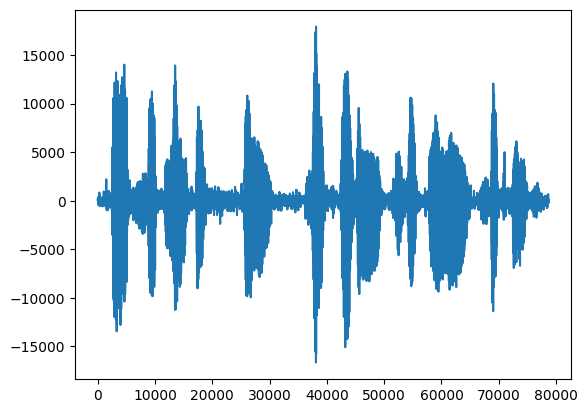

In [51]:
import matplotlib.pyplot as plt
print(dataset[0])
plt.plot(dataset[0][1])
plt.show()

# Eval

In [52]:
import torch
from transformers import AutoProcessor, AutoModelForCTC
clear_output()

In [80]:
# MODEL_ID = "KoelLabs/xlsr-timit-b0"
# MODEL_ID = "KoelLabs/xlsr-timit-c0"
# MODEL_ID = "KoelLabs/xlsr-timit-d0"
# MODEL_ID = "KoelLabs/xlsr-timit-b1"
MODEL_ID = "KoelLabs/xlsr-timit-c1"
# MODEL_ID = "KoelLabs/xlsr-timit-d1"
# MODEL_ID = "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"
# MODEL_ID = "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme"
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
# DEVICE = 'cpu' # force cpu since we run out of memory with mps when using suitcase_corpus
torch.mps.empty_cache()
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = AutoModelForCTC.from_pretrained(MODEL_ID).to(DEVICE)

In [73]:
def transcribe_batch(batch):
    input_values = processor([x[1] for x in batch], sampling_rate=TARGET_SAMPLE_RATE, return_tensors="pt", padding=True).input_values.type(torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    return [processor.decode(ids) for ids in predicted_ids]

In [74]:
transcribe_batch([dataset[0]])

['fɔɹ ðʌ twɛntiθ taɪm ðæt ivnɪŋk ðʌ tu mɛn ʃʊk hænds']

In [68]:
import panphon.distance

def cer(prediction, ground_truth):
    # Convert input lists to strings if they're lists
    if isinstance(prediction, list):
        prediction = "".join(prediction)
    if isinstance(ground_truth, list):
        ground_truth = "".join(ground_truth)

    # Handle empty strings
    if len(ground_truth) == 0:
        return 1.0 if len(prediction) > 0 else 0.0

    # Initialize the matrix
    matrix = np.zeros((len(prediction) + 1, len(ground_truth) + 1))

    # Fill first row and column
    for i in range(len(prediction) + 1):
        matrix[i, 0] = i
    for j in range(len(ground_truth) + 1):
        matrix[0, j] = j

    # Fill in the rest of the matrix
    for i in range(1, len(prediction) + 1):
        for j in range(1, len(ground_truth) + 1):
            if prediction[i - 1] == ground_truth[j - 1]:
                matrix[i, j] = matrix[i - 1, j - 1]
            else:
                substitution = matrix[i - 1, j - 1] + 1
                insertion = matrix[i, j - 1] + 1
                deletion = matrix[i - 1, j] + 1
                matrix[i, j] = min(substitution, insertion, deletion)

    # Calculate CER
    distance = matrix[len(prediction), len(ground_truth)]
    return distance / len(ground_truth)


def preprocess_ipa(ipa_string):
    """Preprocess an IPA string by removing unsupported symbols. Suggestions by David Mortensen, creator of panphon."""
    replacement_map = {
        "ɚ": "ɹ̩",  # Convert /ɚ/ to /ɹ/ (non-syllabic r)
        "ɝ": "ɹ",  # Convert /ɝ/ to /ɹ/ (non-syllabic r)
        "ː": "",  # Remove length mark (or duplicate previous vowel if length is important)
        "͡": "",  # Remove tie bar (or split into components if part of an affricate)
        "g": "ɡ",  # replace two versions of g, TIMIT uses ascii g and STANDARD IPA uses unicode g
    }
    processed_string = "".join(replacement_map.get(char, char) for char in ipa_string)

    return processed_string


def panphon_model_eval(label, predicted):
    label_sequence = preprocess_ipa(label)
    pred_sequence = preprocess_ipa(predicted)

    weighted_feature_dist = panphon.distance.Distance().weighted_feature_edit_distance(
        label_sequence, pred_sequence
    )
    cer_score = cer(predicted, label)

    return cer_score, weighted_feature_dist

In [81]:
BATCH_SIZE = 4
# BATCH_SIZE = 1 
average_cer = 0
average_feature_distance = 0
amount = len(dataset)
for i in range(0, amount, BATCH_SIZE):
    torch.mps.empty_cache()
    size = min(BATCH_SIZE, amount - i)
    transcriptions = transcribe_batch(dataset[i:i+size])
    for j in range(size):
        cer_score, feature_distance = panphon_model_eval(dataset[i+j][0], transcriptions[j])
        average_cer += cer_score
        average_feature_distance += feature_distance

print(f"Average CER: {average_cer / amount}")
print(f"Average feature distance: {average_feature_distance / amount}")

Average CER: 0.8907385118018802
Average feature distance: 111.785


Suitcase:
D0 CER: 2.9379972136515935
D0 WFED: 2376.409090909091

D1 CER: 2.9834309842862363
D1 WFED: 2417.505681818182

Ginic CER: 2.961459943858465
Ginic WFED: 2309.5625

ABA:
B0 CER: 0.8317717036244243
B0 WFED: 102.5675

B1 CER: 0.8587806203319591
B1 WFED: 107.29458333333334

C0 CER: 0.8898473259734988
C0 WFED: 112.07083333333334

C1 CER: 0.8907385118018802
C1 WFED: 111.785

D0 CER: 0.8766673341830556
D0 WFED: 110.37291666666667

D1 CER: 0.8863165244329944
D1 WFED: 111.72416666666666

Ginic CER: 0.8559469969531082
Ginic WFED: 97.88041666666666

ARCTIC Finetune CER: 1.0676152946351227
ARCTIC Finetune WFED: 85.3475